<img src="logo_ue.png" width="400"/>


# ANEXO 1 ANTECEDENTES / ESTADO DEL ARTE #

Importar librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import nltk
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud


Cargar las fuente de información requeridas

In [2]:
df_proyectos        = pd.read_excel("Base Completa de InterOperabilidad Post Ejecución Servicio.xlsx")
df_iniciativas      = pd.read_excel("IniciativasPDET.xlsx", sheet_name="Iniciativas")
df_municipios_ref   = pd.read_csv("MunicipiosColombia.csv", delimiter=';')

## Figura 2.1. Distribución de Iniciativas PDET por Pilar

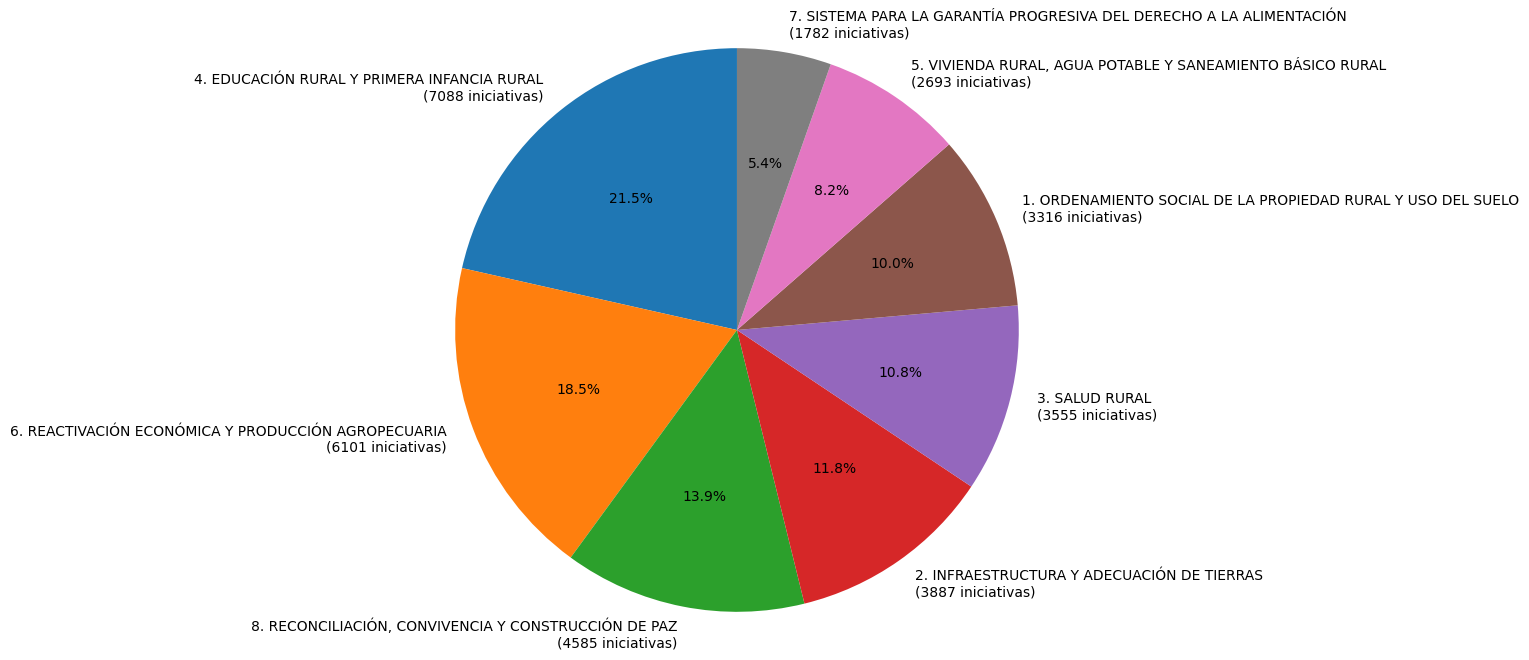

In [3]:
df_iniciativas.columns = df_iniciativas.columns.str.strip() #Eliminar espacios
iniciativas_por_pilar = df_iniciativas['Pilar'].value_counts() #Número de iniciativas por pilar

plt.figure(figsize=(8,8))
plt.pie(iniciativas_por_pilar, labels=[f'{pilar}\n({cantidad} iniciativas)' for pilar, cantidad in zip(iniciativas_por_pilar.index, iniciativas_por_pilar)], autopct='%1.1f%%', startangle=90)
plt.axis('equal')  
plt.show()

# Figura 2.2. Cantidad de iniciativas por Subregión

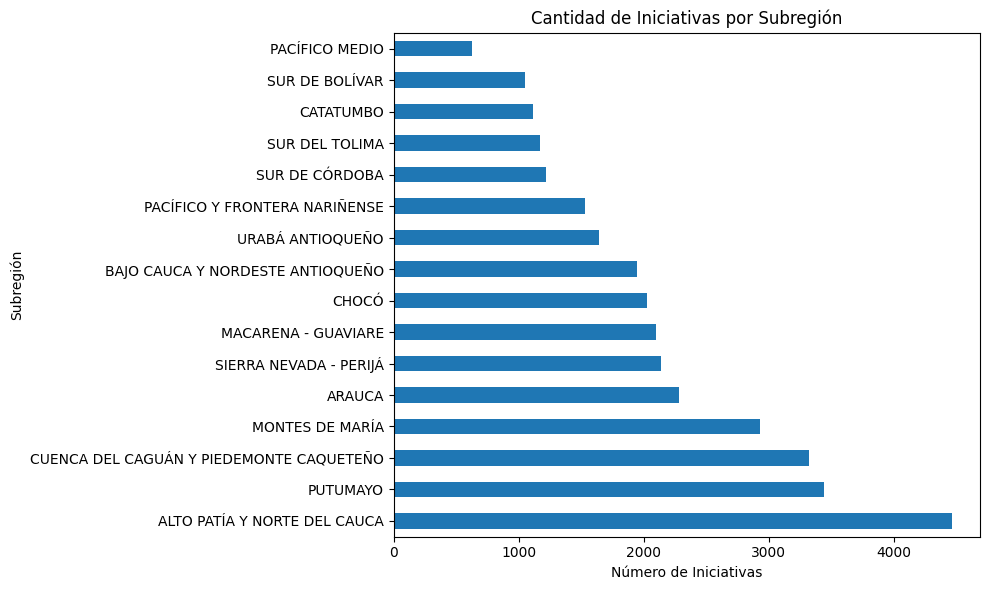

In [4]:
# Iniciativas por subregión
plt.figure(figsize=(10,6))
df_iniciativas['Subregión'].value_counts().plot(kind='barh')
plt.title('Cantidad de Iniciativas por Subregión')
plt.xlabel('Número de Iniciativas')
plt.tight_layout()
plt.show()

# Figura 2.3. Relación número de municipios y la cantidad de iniciativas PDET por Subregión

Correlación entre iniciativas y municipios por subregión: 0.74


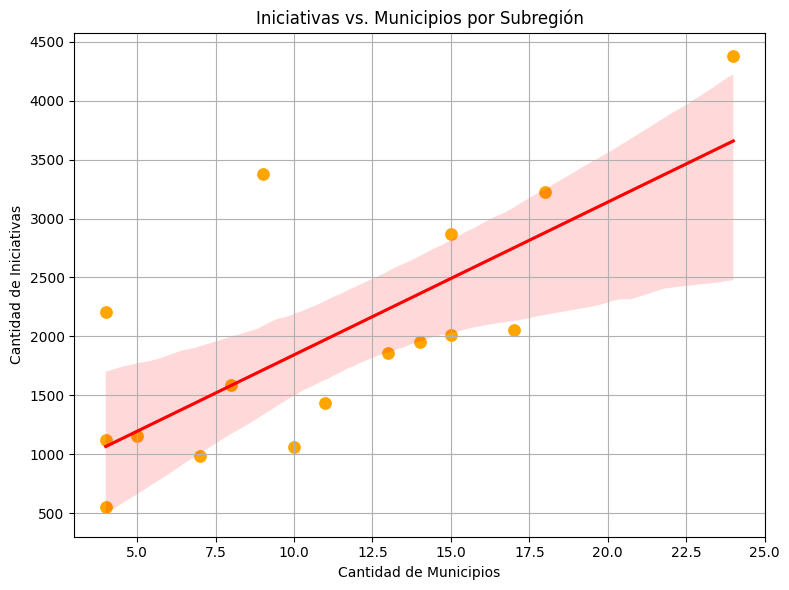

In [5]:
df_filtrado = df_iniciativas[['Subregión', 'Municipio/Sujeto Concertación']] #Obtener columnas necesarias
df_filtrado = df_filtrado.dropna(subset=['Subregión', 'Municipio/Sujeto Concertación']) # Eliminar registros con valores nulos en las columnas
iniciativas_por_subregion = df_filtrado.groupby('Subregión').size().rename('CantidadIniciativas') # Calcular la cantidad de iniciativas por subregión
municipios_por_subregion = df_filtrado.groupby('Subregión')['Municipio/Sujeto Concertación'].nunique().rename('CantidadMunicipios') # Calcular la cantidad de municipios únicos por subregión

df_correlacion = pd.concat([iniciativas_por_subregion, municipios_por_subregion], axis=1) #unir 
correlacion = df_correlacion.corr().iloc[0, 1] # Calcular la correlación
print(f"Correlación entre iniciativas y municipios por subregión: {correlacion:.2f}")

plt.figure(figsize=(8,6))
sns.scatterplot(x='CantidadMunicipios', y='CantidadIniciativas', data=df_correlacion, color='orange', s=100)
sns.regplot(x='CantidadMunicipios', y='CantidadIniciativas', data=df_correlacion, scatter=False, color='red')
plt.title('Iniciativas vs. Municipios por Subregión')
plt.xlabel('Cantidad de Municipios')
plt.ylabel('Cantidad de Iniciativas')
plt.grid(True)
plt.tight_layout()
plt.show()

# Figura 2.4. Distribución Iniciativas PDET por Pilar y Subregión

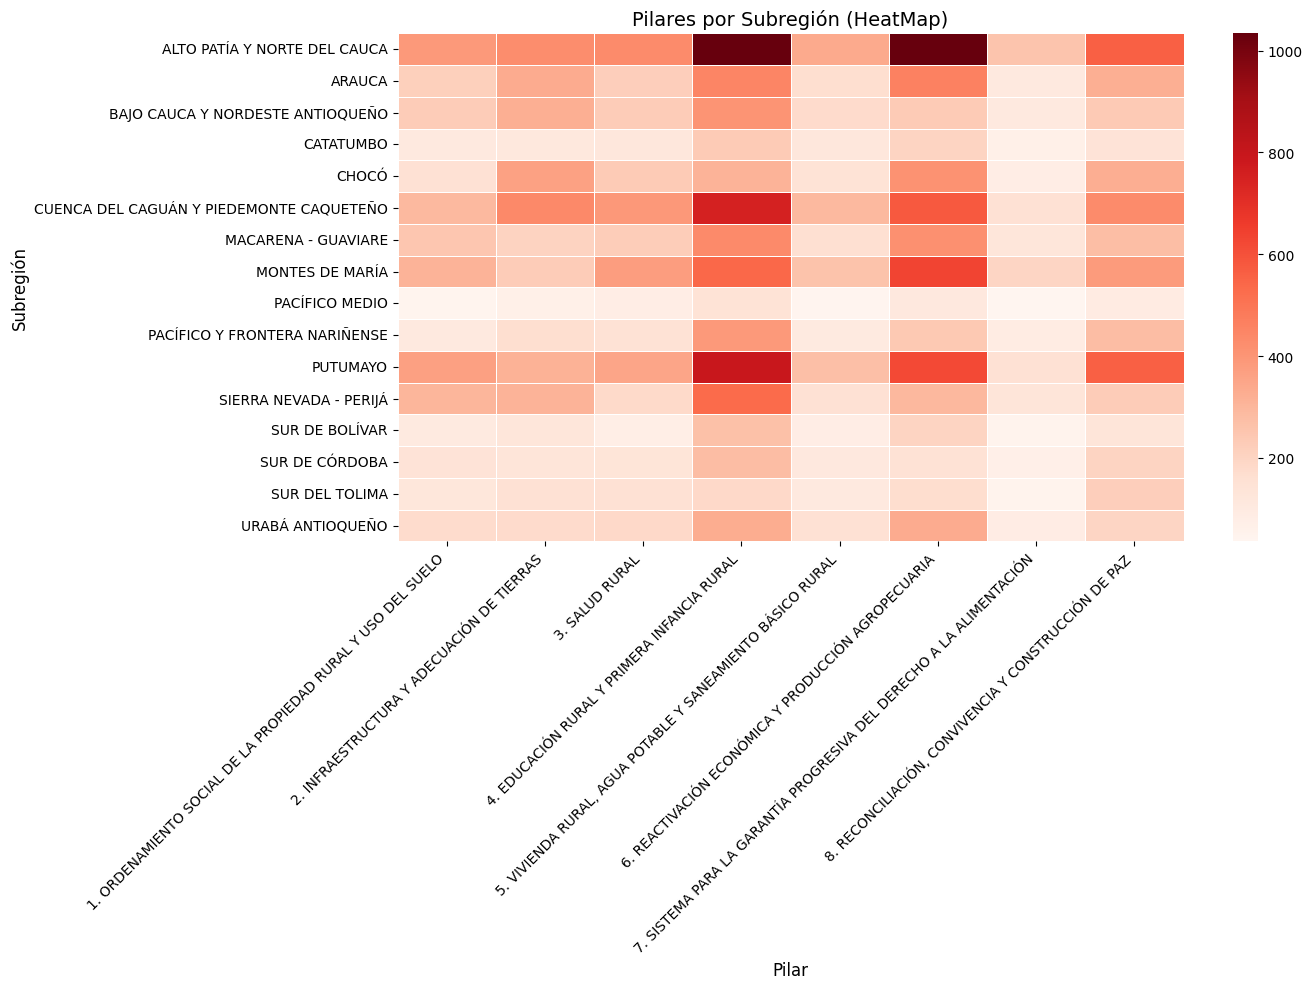

In [6]:
pilares_por_subregion = pd.crosstab(df_iniciativas['Subregión'], df_iniciativas['Pilar']) # iniciativas por subregión y pilar

plt.figure(figsize=(14, 10))
sns.heatmap(pilares_por_subregion, cmap="Reds", linewidths=0.5, annot=False)

plt.title('Pilares por Subregión (HeatMap)', fontsize=14)
plt.xlabel('Pilar', fontsize=12)
plt.ylabel('Subregión', fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

# Figura 2.5. Distribución de longitud de los campos de titulo y descripción en las iniciativas PDET

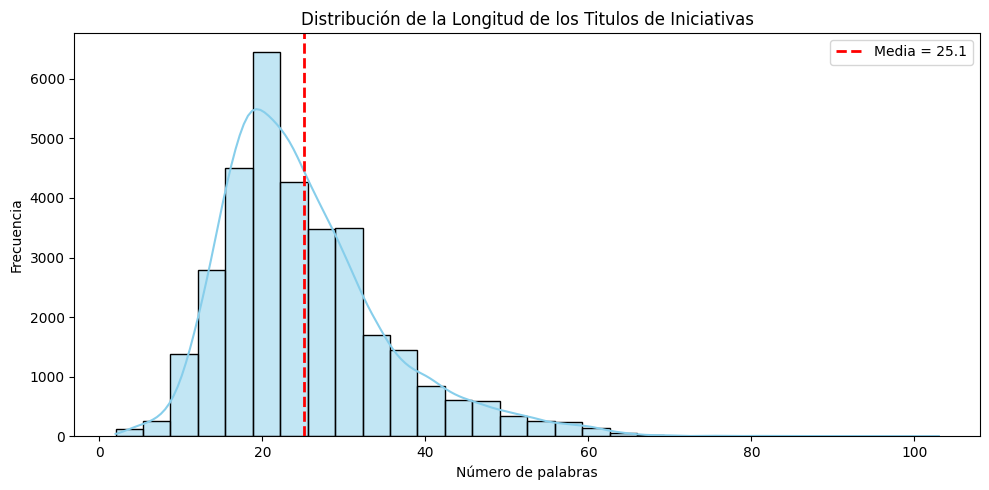

In [7]:
df_iniciativas['long_tit'] = df_iniciativas['Título iniciativa'].astype(str).apply(lambda x: len(x.split())) # Longitud de los títulos
media_desc = df_iniciativas['long_tit'].mean() # media

plt.figure(figsize=(10,5))
sns.histplot(df_iniciativas['long_tit'], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.axvline(media_desc, color='red', linestyle='--', linewidth=2, label=f'Media = {media_desc:.1f}')
plt.title('Distribución de la Longitud de los Titulos de Iniciativas')
plt.xlabel('Número de palabras')
plt.ylabel('Frecuencia')
plt.legend()
plt.tight_layout()
plt.show()

# Figura 2.5. Distribución de longitud de los campos de titulo y descripción en las iniciativas PDET

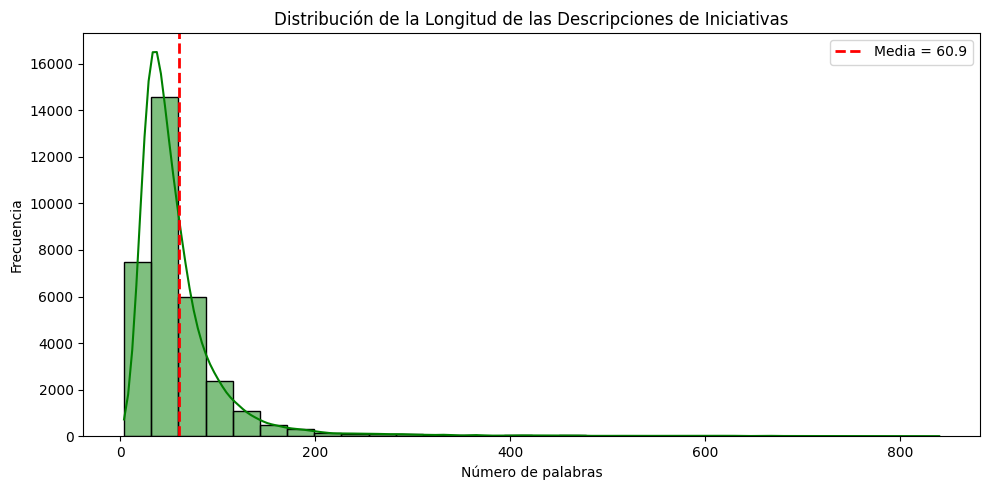

In [8]:
df_iniciativas['long_desc'] = df_iniciativas['Descripción iniciativa'].astype(str).apply(lambda x: len(x.split())) # Longitud de los descripción
media_desc = df_iniciativas['long_desc'].mean() # media

plt.figure(figsize=(10,5))
sns.histplot(df_iniciativas['long_desc'], bins=30, kde=True, color='green', edgecolor='black')
plt.axvline(media_desc, color='red', linestyle='--', linewidth=2, label=f'Media = {media_desc:.1f}')
plt.title('Distribución de la Longitud de las Descripciones de Iniciativas')
plt.xlabel('Número de palabras')
plt.ylabel('Frecuencia')
plt.legend()
plt.tight_layout()
plt.show()

# Figura 2.6. Nubes de palabras por pilar de las iniciativas PDET

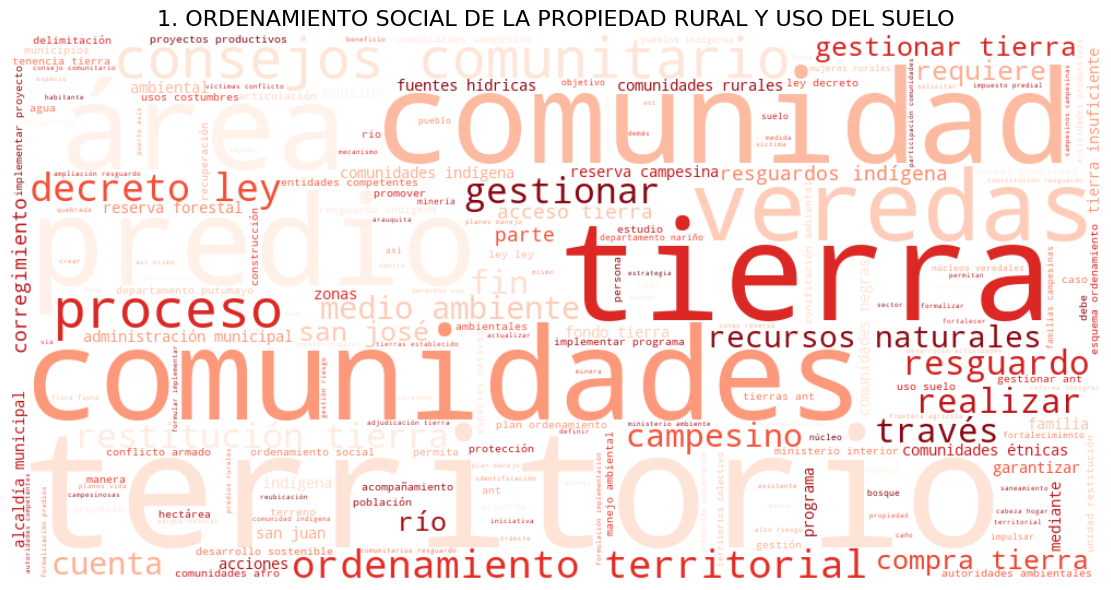

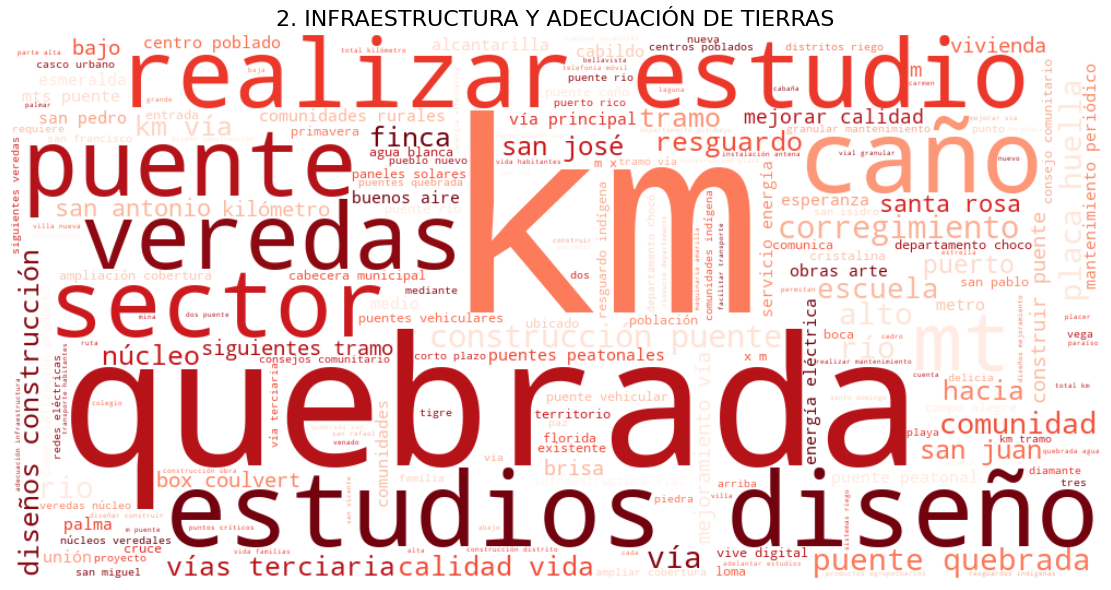

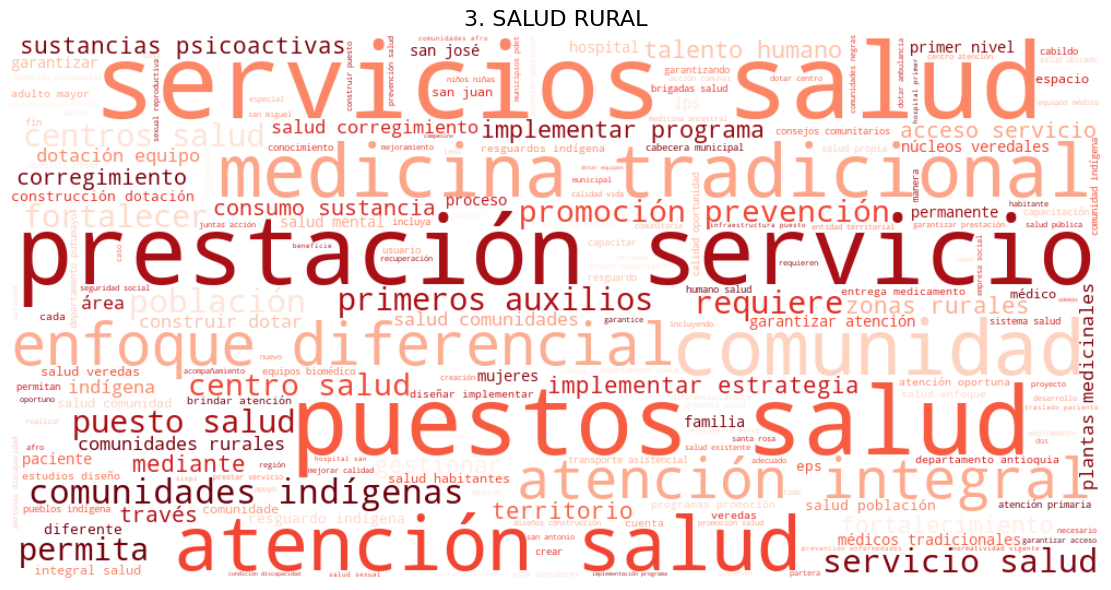

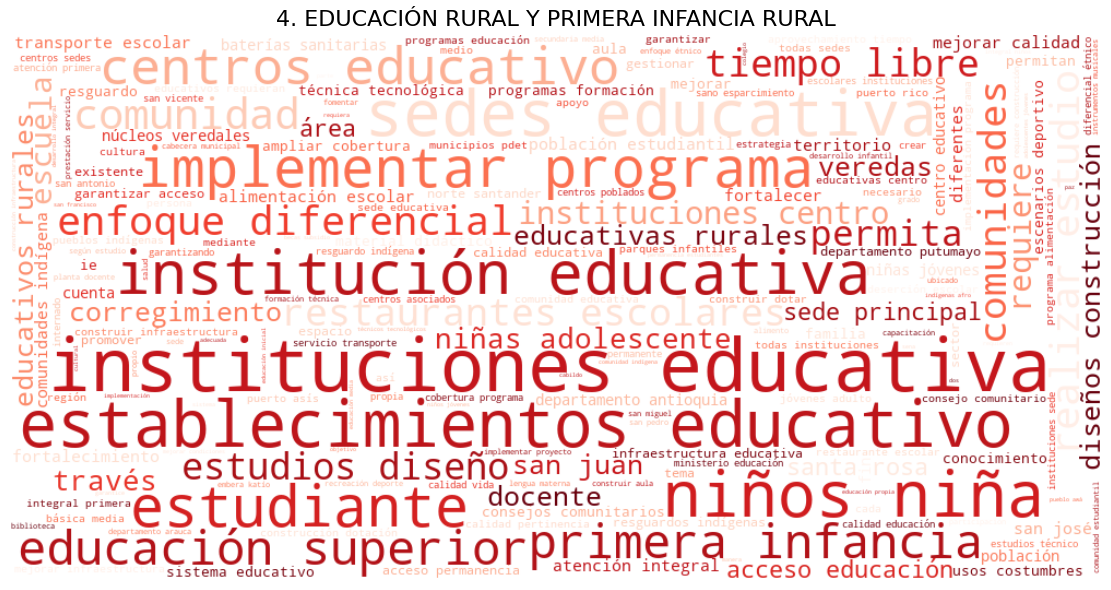

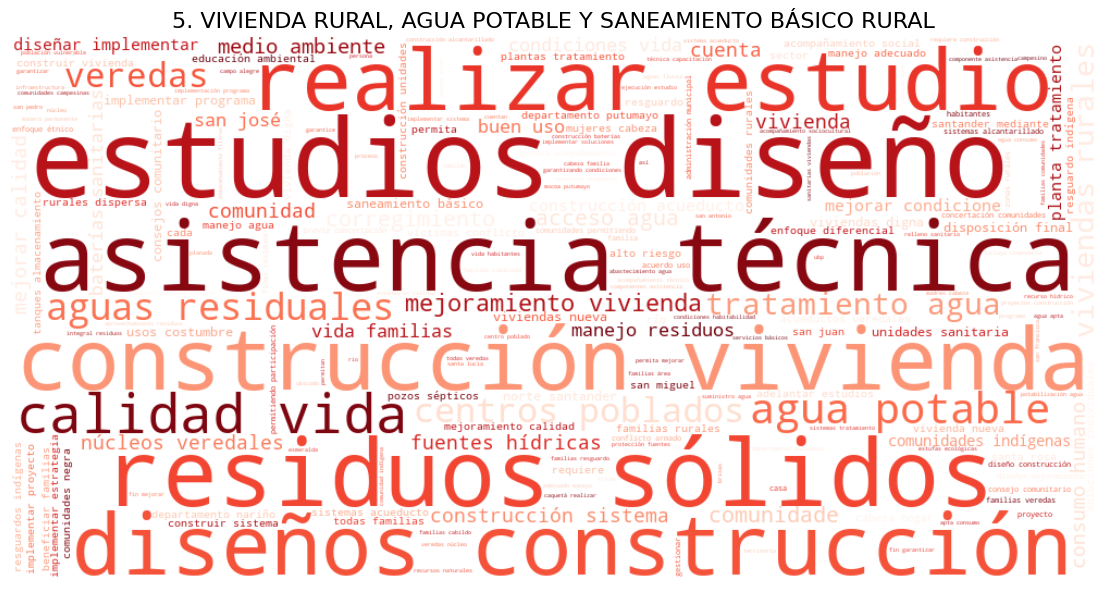

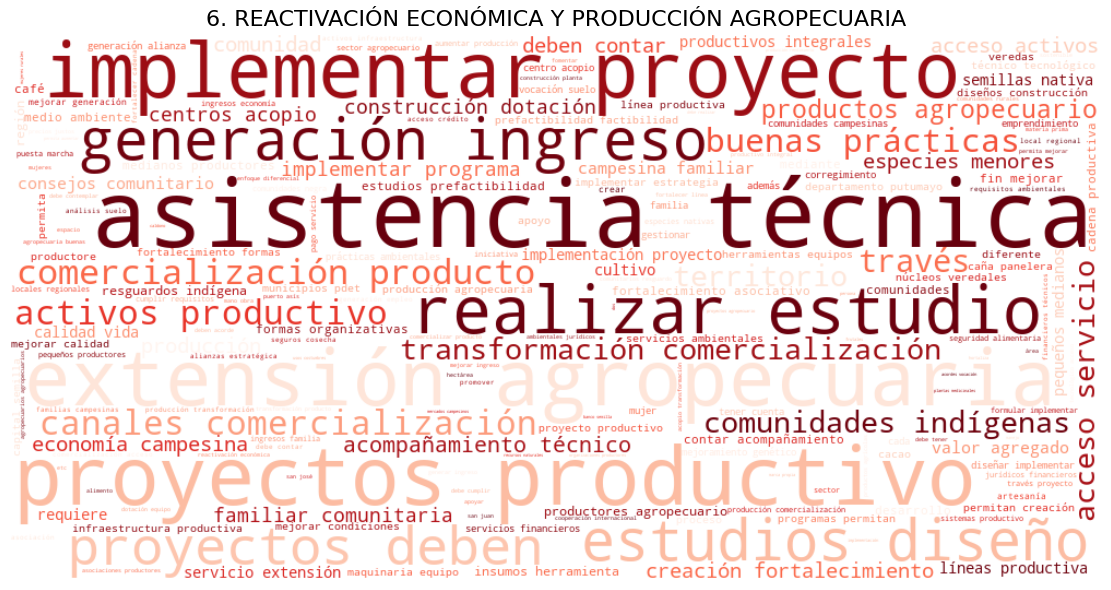

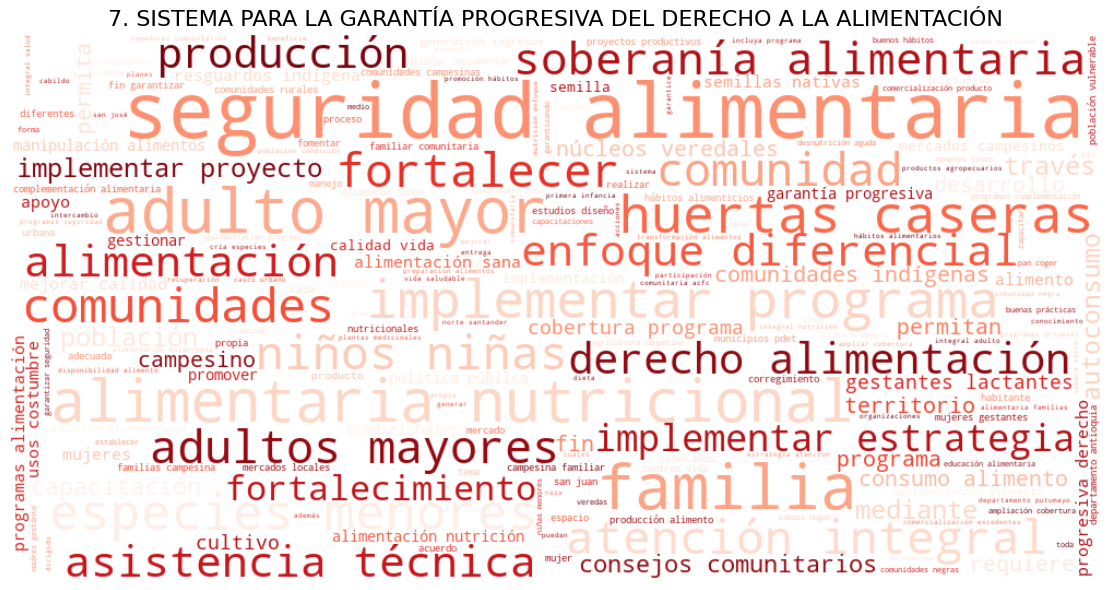

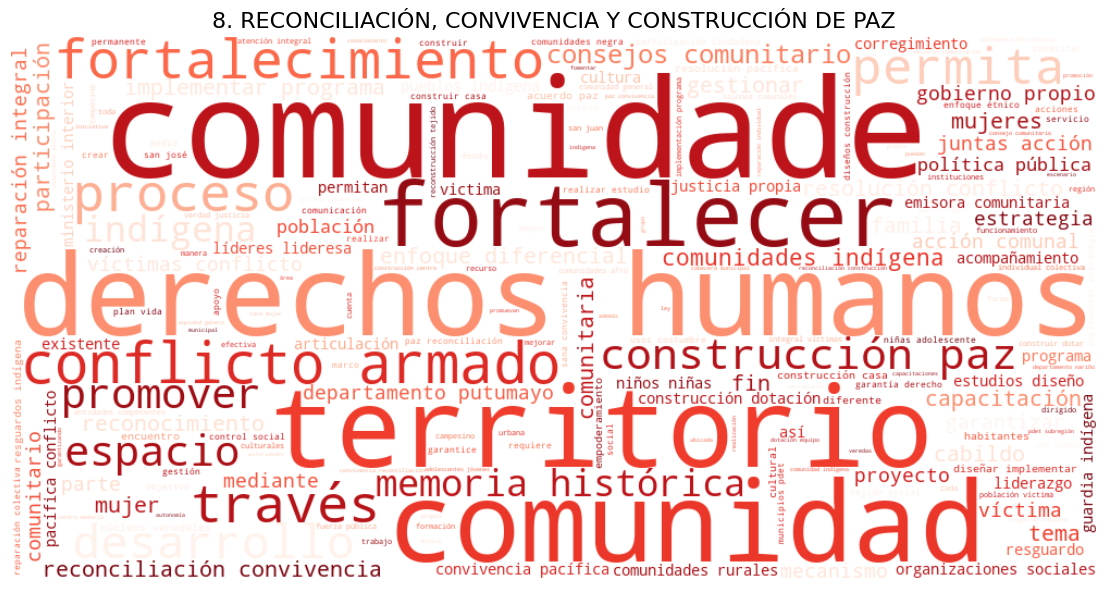

In [9]:
stop_words = set(stopwords.words('spanish'))
stop_words.update(['agencia', 'nacional', 'rural', 'zona', 'municipio','vereda']) #se retiran palabras de manera manual

df_filtrado = df_iniciativas[['Pilar', 'Descripción iniciativa']].dropna()
pilares = sorted(df_filtrado['Pilar'].unique()) #lista de pilares

def limpiar_texto(texto): # Limpiar texto
    texto = re.sub(r'[^\w\s]', '', texto.lower())  # quitar signos de puntuación y pasar a minúsculas
    return ' '.join([word for word in texto.split() if word not in stop_words])

#Nube por pilar
for pilar in pilares:
    textos = df_filtrado[df_filtrado['Pilar'] == pilar]['Descripción iniciativa'].astype(str)
    texto_completo = ' '.join(textos.map(limpiar_texto))
    
    wordcloud = WordCloud(
        width=1000, height=500, 
        background_color='white', 
        colormap='Reds'
    ).generate(texto_completo)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(pilar, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## 

# Figura 2.7. Nube de palabras proyectos de inversión pública

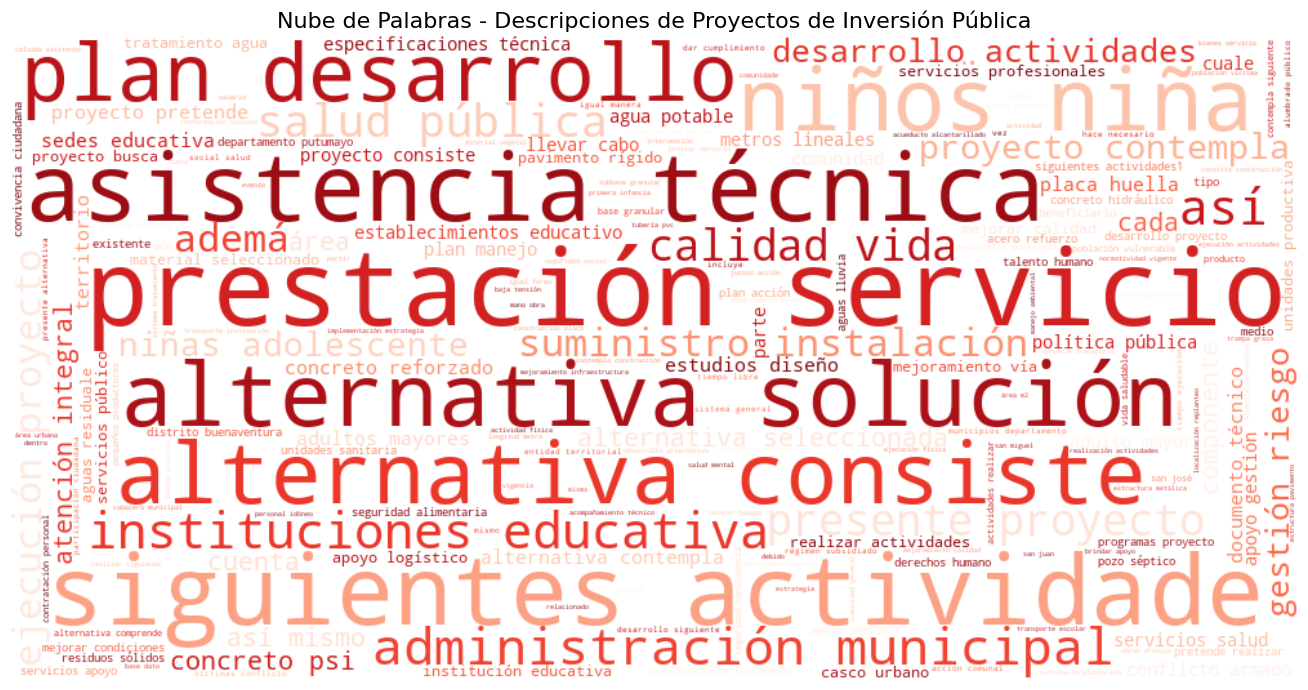

In [10]:
textos = df_proyectos['Descripcion'].dropna().astype(str)
texto_completo = ' '.join(textos.map(limpiar_texto))

# Nube de palabras
wordcloud = WordCloud(
    width=1000, height=500, 
    background_color='white', 
    colormap='Reds'  # Escala de rojos
).generate(texto_completo)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras - Descripciones de Proyectos de Inversión Pública', fontsize=16)
plt.tight_layout()
plt.show()

# Figura 2.8. Distribución de longitud de los campos de nombre, descripción y objetivo de los Proyectos de Inversión Pública en Colombia

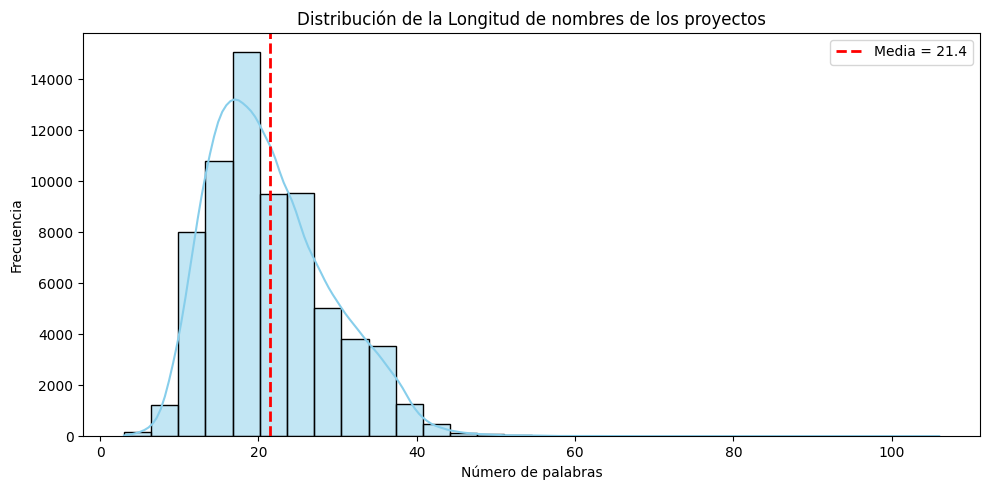

In [11]:
df_proyectos['long_nombre'] = df_proyectos['Nombre'].astype(str).apply(lambda x: len(x.split())) # Longitud de los nombres de los proyectos 
media_desc = df_proyectos['long_nombre'].mean() #Media

plt.figure(figsize=(10,5))
sns.histplot(df_proyectos['long_nombre'], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.axvline(media_desc, color='red', linestyle='--', linewidth=2, label=f'Media = {media_desc:.1f}')
plt.title('Distribución de la Longitud de nombres de los proyectos')
plt.xlabel('Número de palabras')
plt.ylabel('Frecuencia')
plt.legend()
plt.tight_layout()
plt.show()

# Figura 2.8. Distribución de longitud de los campos de nombre, descripción y objetivo de los Proyectos de Inversión Pública en Colombia

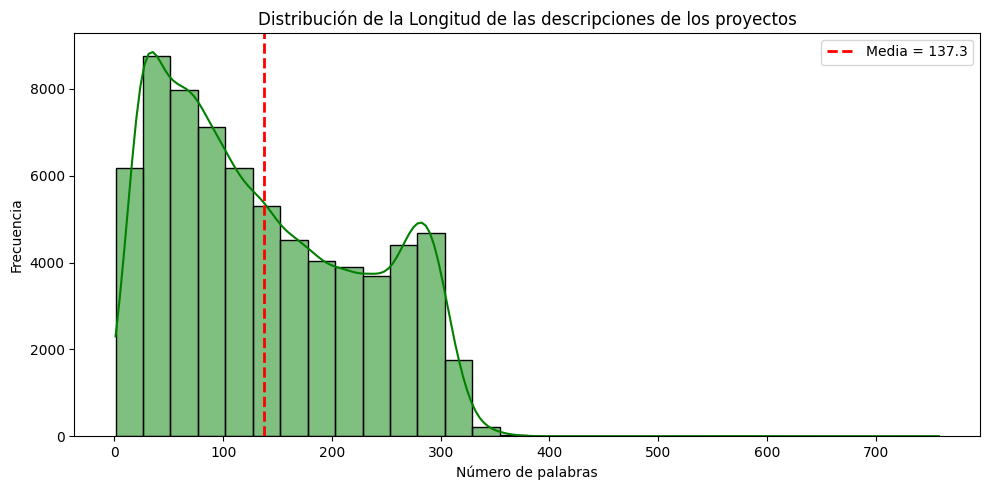

In [12]:
df_proyectos['long_descripcion'] = df_proyectos['Descripcion'].astype(str).apply(lambda x: len(x.split())) # Longitud Descripcion
media_desc = df_proyectos['long_descripcion'].mean() #Media

plt.figure(figsize=(10,5))
sns.histplot(df_proyectos['long_descripcion'], bins=30, kde=True, color='green', edgecolor='black')
plt.axvline(media_desc, color='red', linestyle='--', linewidth=2, label=f'Media = {media_desc:.1f}')
plt.title('Distribución de la Longitud de las descripciones de los proyectos')
plt.xlabel('Número de palabras')
plt.ylabel('Frecuencia')
plt.legend()
plt.tight_layout()
plt.show()

# Figura 2.8. Distribución de longitud de los campos de nombre, descripción y objetivo de los Proyectos de Inversión Pública en Colombia

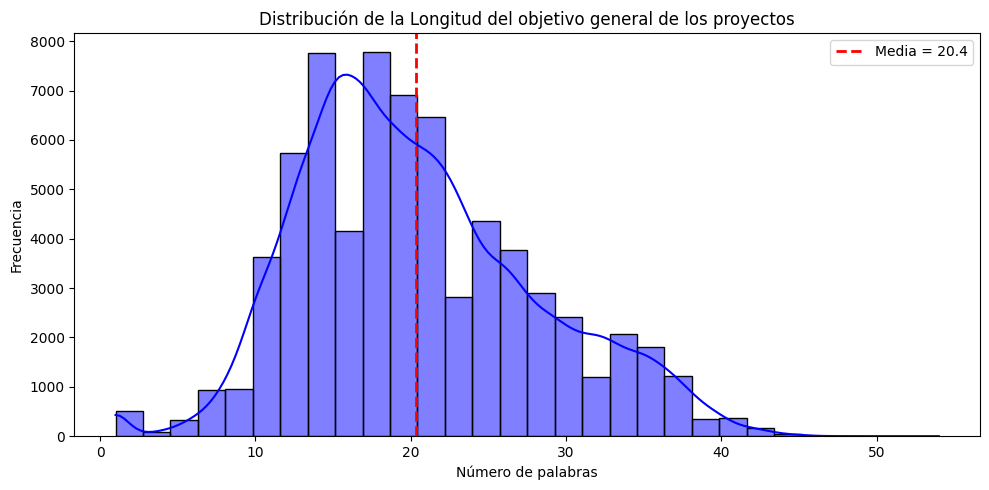

In [13]:
df_proyectos['long_objetivogeneral'] = df_proyectos['ObjetivoGeneral'].astype(str).apply(lambda x: len(x.split())) # Longitud Objetivo
media_desc = df_proyectos['long_objetivogeneral'].mean() #Media

plt.figure(figsize=(10,5))
sns.histplot(df_proyectos['long_objetivogeneral'], bins=30, kde=True, color='blue', edgecolor='black')
plt.axvline(media_desc, color='red', linestyle='--', linewidth=2, label=f'Media = {media_desc:.1f}')
plt.title('Distribución de la Longitud del objetivo general de los proyectos')
plt.xlabel('Número de palabras')
plt.ylabel('Frecuencia')
plt.legend()
plt.tight_layout()
plt.show()